# ADSP Final Project Stock Price Prediction 

In [49]:
import pandas as pd
import numpy as np
import scipy as sp
from Data import * 
from Model import * 
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from prophet.diagnostics import cross_validation
from prophet import Prophet
from arch import arch_model
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.bats import BATS

## 0. Data Fetching 

In [2]:
DAL = get_ETF_data('DAL', '2000-01-01', '2024-01-01')
#MSFT.to_csv('msft.csv', index=True)

In [3]:
temp_DAL = DAL.resample('M').mean() 

In [4]:
train_dal, val_dal, test_dal = split_time_series(DAL, 0.6,0.2)
#train_msft.to_csv('train_msft.csv', index=True)
#val_msft.to_csv('val_msft.csv', index=True)
#test_msft.to_csv('test_msft.csv', index=True)

In [5]:
display(DAL.head(5))

,adj_close
date,
2007-05-03,18.240466
2007-05-04,18.469352
2007-05-07,17.923546
2007-05-08,17.280905
2007-05-09,17.421758


## 1. EDA 

In [6]:
check_data_summary(DAL)

Number of rows: 4195
Number of columns: 1
Column names:
Index(['adj_close'], dtype='object')
Data types:
adj_close    float64
dtype: object
Summary statistics:
         adj_close
count  4195.000000
mean     29.232412
std      16.676037
min       3.459702
25%      10.806067
50%      33.101171
75%      42.996531
max      61.692342
Missing values:
adj_close    0
dtype: int64
No duplicated index values.


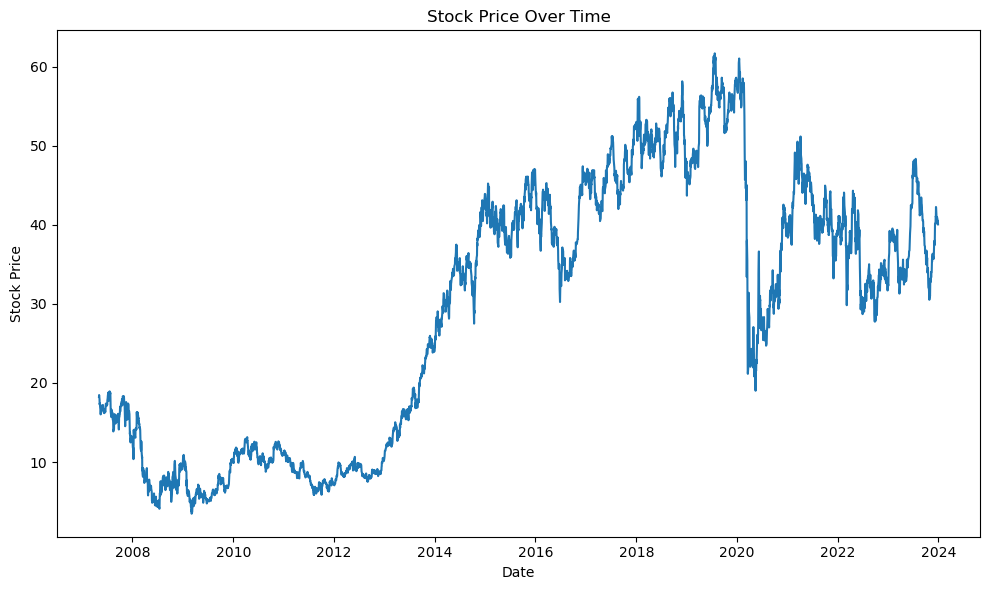

In [7]:
plot_stock_price(DAL)

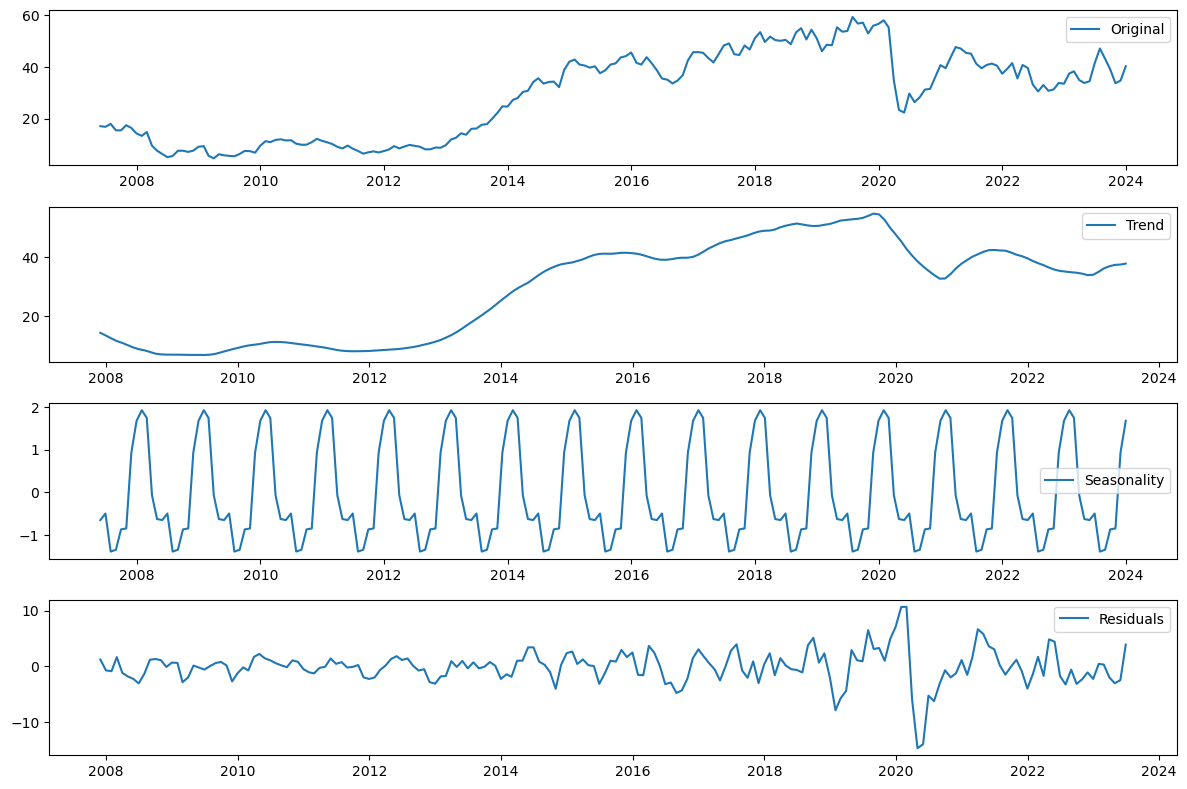

In [8]:
decompose_and_plot(temp_DAL,12)

In [9]:
check_stationarity(train_dal)

Results of Dickey-Fuller Test for adj_close:
Test Statistic                   -0.324948
p-value                           0.921896
#Lags Used                        0.000000
Number of Observations Used    2516.000000
Critical Value (1%)              -3.432952
Critical Value (5%)              -2.862689
Critical Value (10%)             -2.567382
dtype: float64
Results of KPSS Test for adj_close:
Test Statistic            6.366764
p-value                   0.010000
Lags Used                30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
adj_close time series data is not stationary


<Figure size 600x300 with 0 Axes>

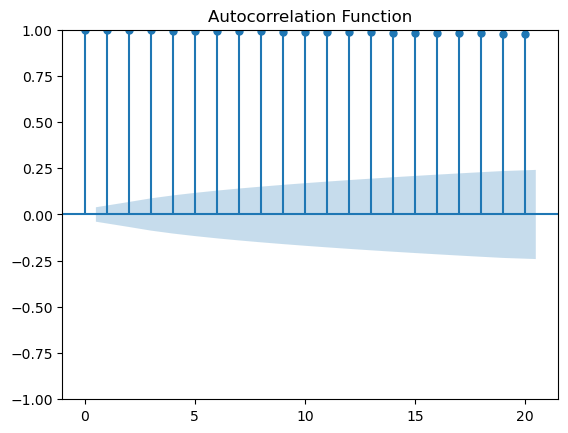

<Figure size 600x300 with 0 Axes>

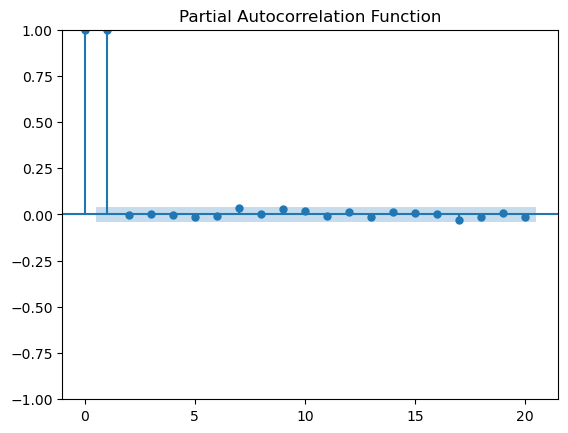

In [10]:
plot_time_series_analysis(train_dal,'adj_close')

## 2.Smoothing

In [11]:
model = fit_smoothing(train_dal)
y_test = val_dal 
y_pred = model.forecast(len(y_test))
y_pred.index = y_test.index

In [12]:
result = tune_param(train_dal,val_dal['adj_close'],methods=['add','mul'],periods=[4,12,24,36])
result

,methods,periods,mae,mse,mape,smape
0,add,4,8.827398,119.821795,0.233056,0.200272
1,add,12,8.8344,119.872404,0.233167,0.200433
2,add,24,8.911863,120.290161,0.234253,0.202216
3,add,36,8.668745,118.78243,0.230683,0.19665
4,mul,4,7.972316,139.190229,0.233477,0.179412
5,mul,12,7.947088,140.163074,0.233559,0.178782
6,mul,24,8.063063,139.485476,0.234964,0.181447
7,mul,36,7.578025,150.236378,0.232373,0.169783


In [13]:
best_param = result.loc[result['smape'].idxmin(), ['methods', 'periods']].tolist()
best_param 

['mul', 36]

## 3.ARIMA 

In [14]:
check_num_stationarity(train_dal['adj_close'])

The time series data is stationary.
Number of differencing needed is: 1


In [15]:
train_dal_diff = train_dal.loc[:,['adj_close']].diff().dropna()
check_stationarity(train_dal_diff)

Results of Dickey-Fuller Test for adj_close:
Test Statistic                  -49.852414
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2515.000000
Critical Value (1%)              -3.432953
Critical Value (5%)              -2.862690
Critical Value (10%)             -2.567382
dtype: float64
Results of KPSS Test for adj_close:
Test Statistic           0.2573
p-value                  0.1000
Lags Used                1.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64
adj_close time series data is stationary


<Figure size 600x300 with 0 Axes>

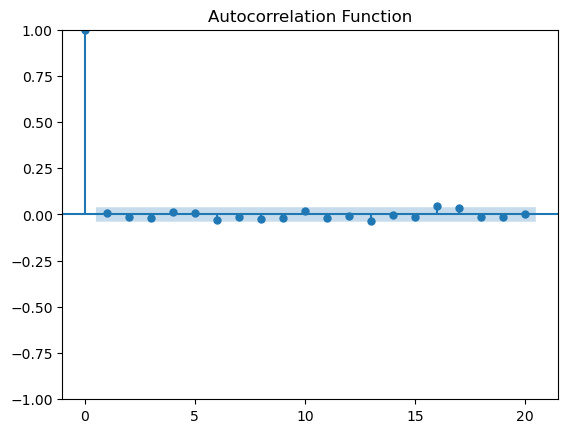

<Figure size 600x300 with 0 Axes>

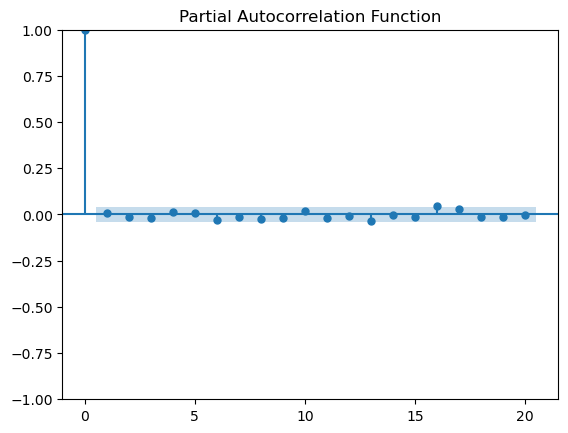

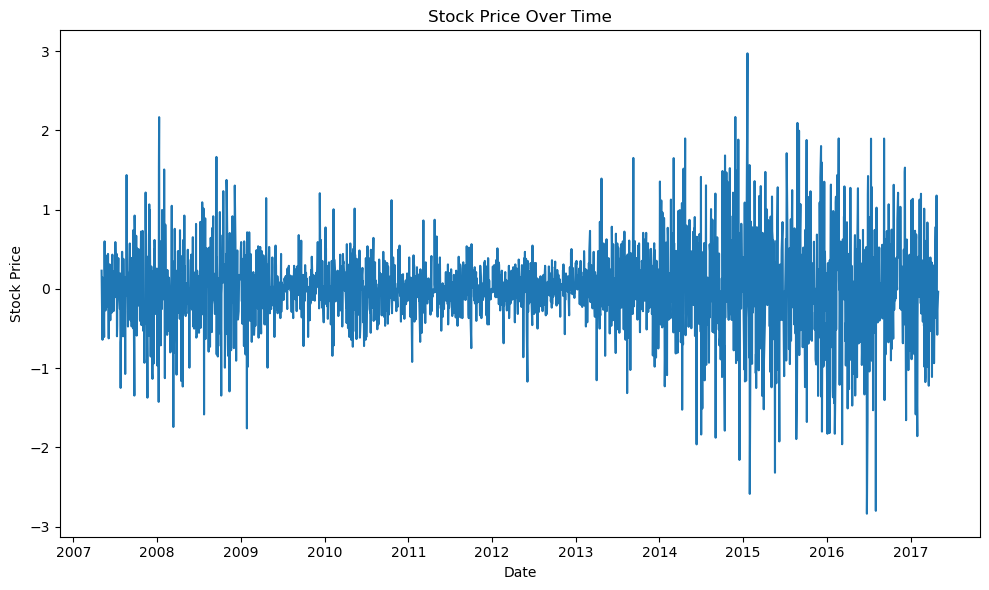

In [16]:
plot_time_series_analysis(train_dal_diff,'adj_close')
plot_stock_price(train_dal_diff)

In [17]:
arma_model = ARIMA(train_dal, order=(0,1,0))
model_fit = arma_model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              adj_close   No. Observations:                 2517
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1979.499
Date:                Thu, 23 May 2024   AIC                           3960.998
Time:                        19:11:19   BIC                           3966.828
Sample:                             0   HQIC                          3963.114
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2824      0.005     56.654      0.000       0.273       0.292
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1024.72
Prob(Q):                              0.78   Pr

'Ljung-Box Test Results:'

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,8.141111,0.615056,8.110402,0.618054


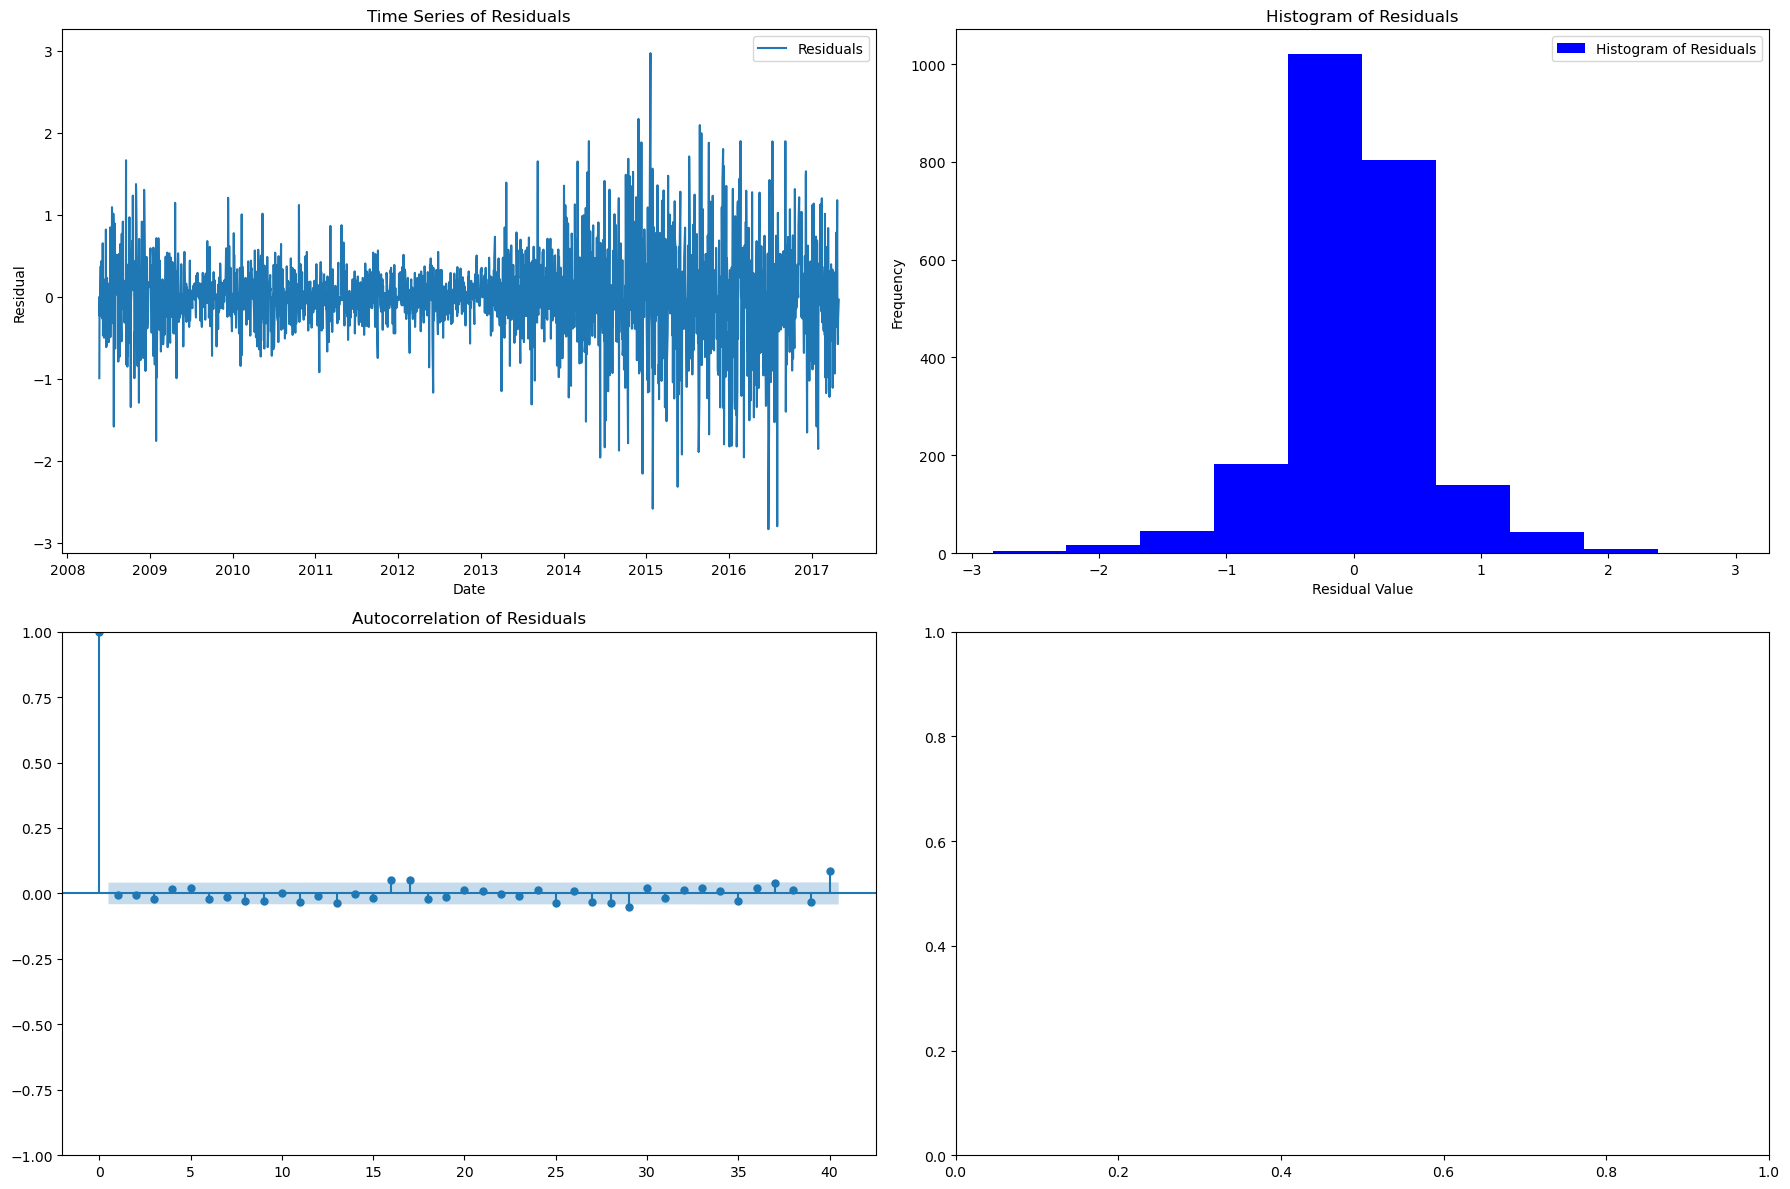

In [18]:
analyze_residuals(model_fit.resid[252:])

In [19]:
predictions_arima = model_fit.forecast(steps = len(val_dal))
evaluate_forecast(val_dal['adj_close'], predictions_arima)

,MAE,MSE,MAPE (%),sMAPE (%)
0,10.604609,133.656219,24.601304,24.2591


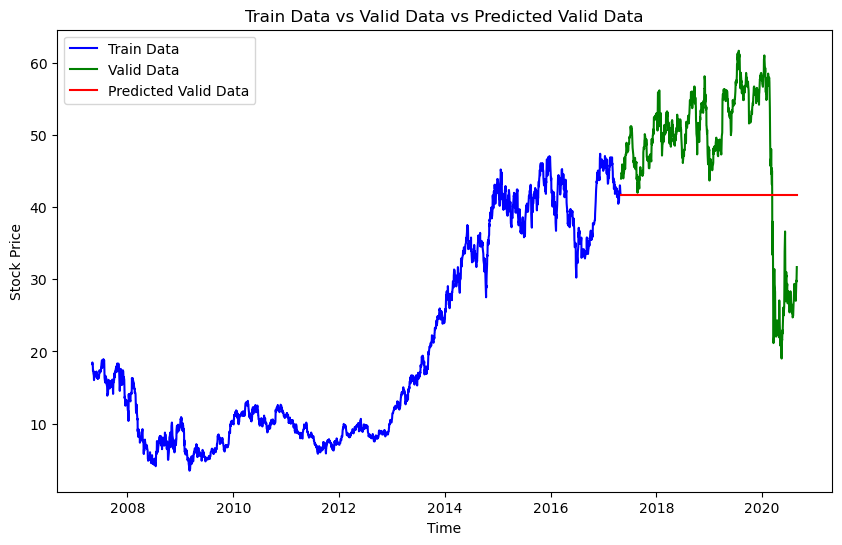

In [20]:
plot_line_graph(train_dal['adj_close'], val_dal['adj_close'], predictions_arima)

## 4.SARIMA

In [21]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=train_dal,order=(1,1,1), seasonal_order=(0, 1, 0, 64)).fit(method='cg')
display(sarima_model.summary())

Optimization terminated successfully.
         Current function value: 1.093320
         Iterations: 23
         Function evaluations: 51
         Gradient evaluations: 51


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           adj_close   No. Observations:                 2517
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 64)   Log Likelihood               -4450.643
Date:                             Thu, 23 May 2024   AIC                           8907.285
Time:                                     19:17:24   BIC                           8924.699
Sample:                                          0   HQIC                          8913.614
                                            - 2517                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3754      0.012     31.075      0.000       0.352       0.399
ma.L1          0.3890      0.007     55.728      0.000       0.375       0.403
sigma2         0.3053      0.003     91.684      0.000       0.299       0.312
===================================================================================
Ljung-Box (L1) (Q):                 867.93   Jarque-Bera (JB):               386.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

'Ljung-Box Test Results:'

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,988.979201,4.424178e-206,987.518964,9.127619e-206


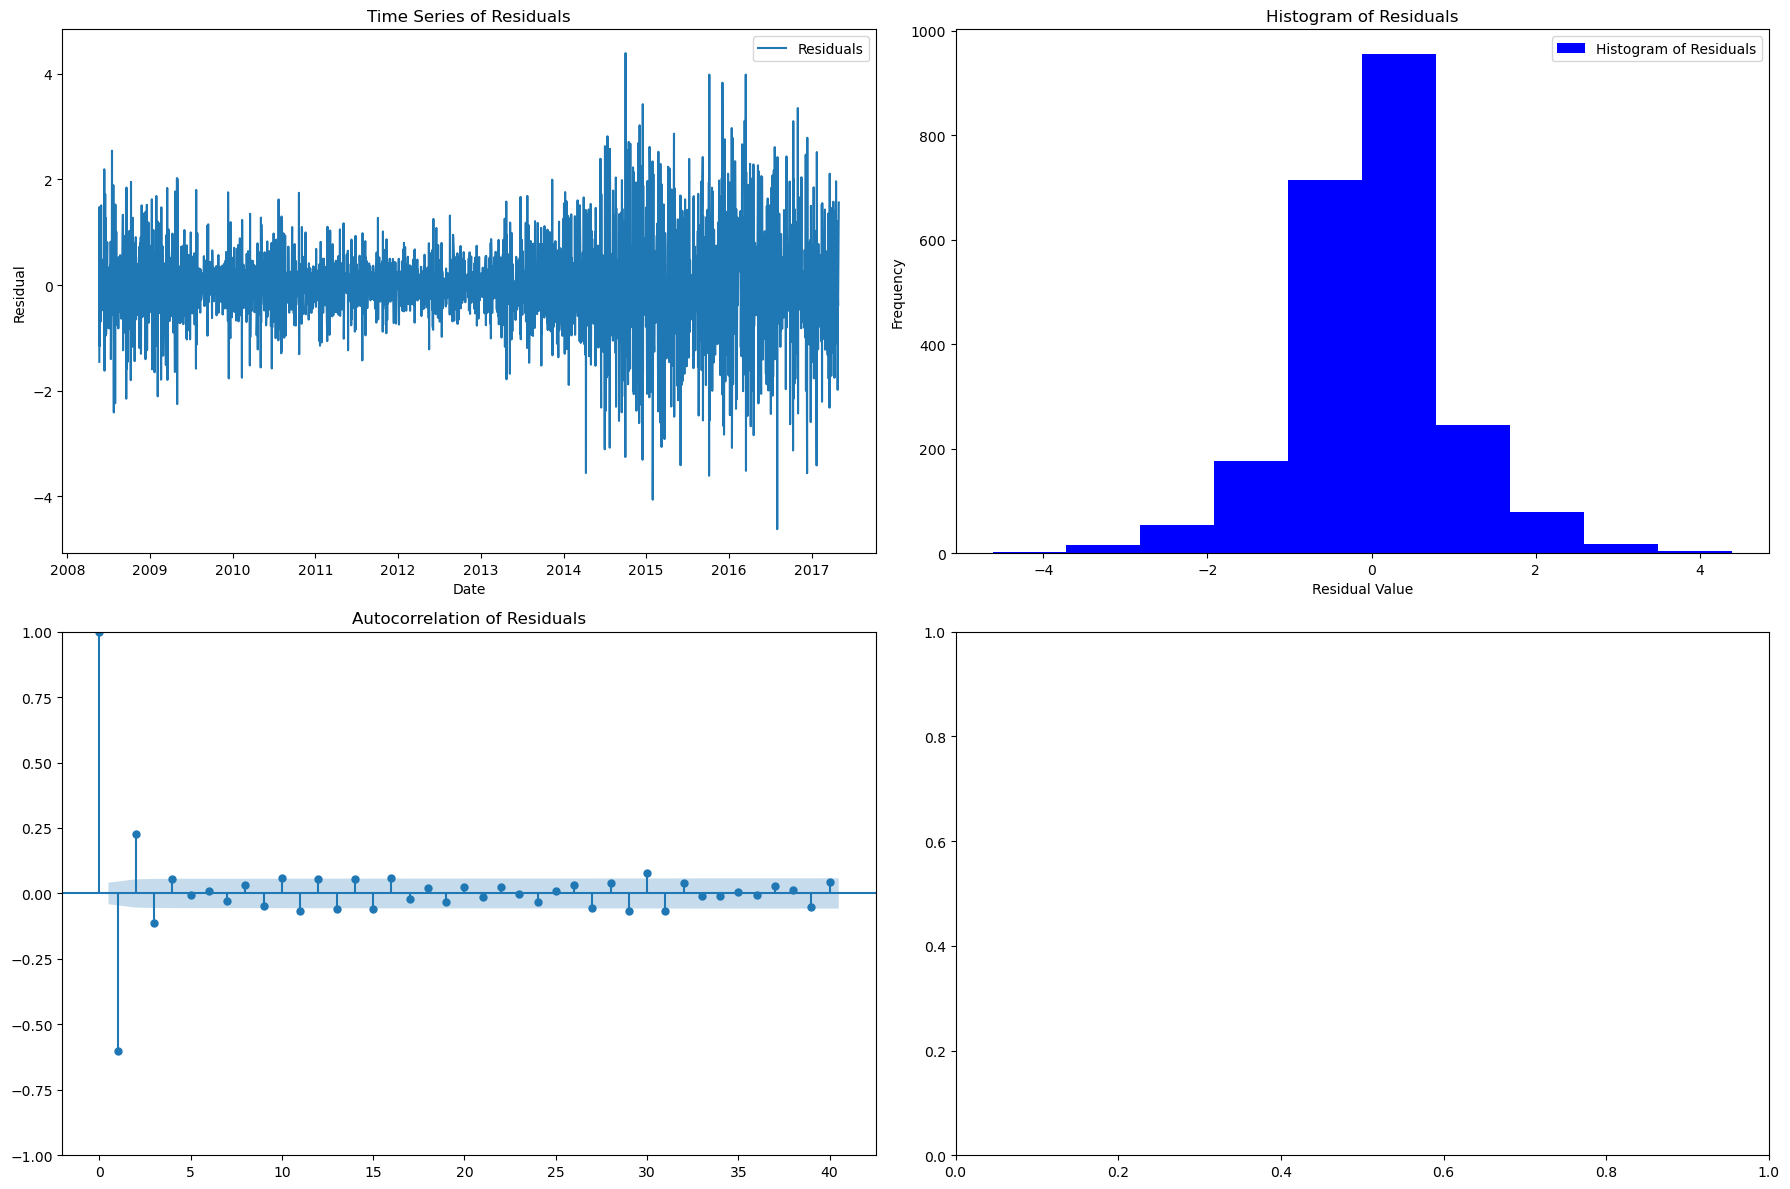

In [22]:
resid = sarima_model.resid
analyze_residuals(resid[252:])

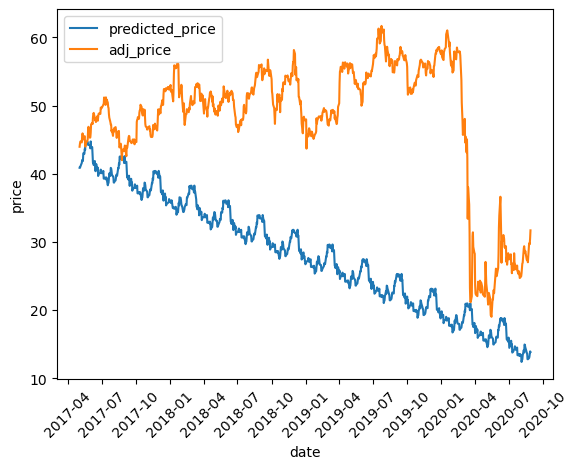

In [23]:
val_pred=sarima_model.forecast(steps = len(val_dal)).to_frame()
val_pred.index = val_dal.index
plt.plot(val_pred['predicted_mean'], label='predicted_price')
plt.plot(val_dal['adj_close'], label='adj_price')
plt.xlabel('date')
plt.ylabel('price')
# Set the locator
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
plt.gca().xaxis.set_major_locator(locator)
# Rotate dates for better readability
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [24]:
predictions_sarima = sarima_model.forecast(steps = len(val_dal))
evaluate_forecast(val_dal['adj_close'], predictions_sarima)

,MAE,MSE,MAPE (%),sMAPE (%)
0,19.734925,500.776363,39.873912,52.616187


## 5.Auto-ARIMA

In [25]:
autoarima_model = pm.auto_arima(train_dal, d=1, D=1, m=64, seasonal=False, stepwise=True)

In [26]:
autoarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2517
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1979.499
Date:                Thu, 23 May 2024   AIC                           3960.998
Time:                        19:17:30   BIC                           3966.828
Sample:                             0   HQIC                          3963.114
                               - 2517                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2824      0.005     56.654      0.000       0.273       0.292
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1024.72
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.82   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

'Ljung-Box Test Results:'

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,8.150207,0.614168,8.119542,0.617161


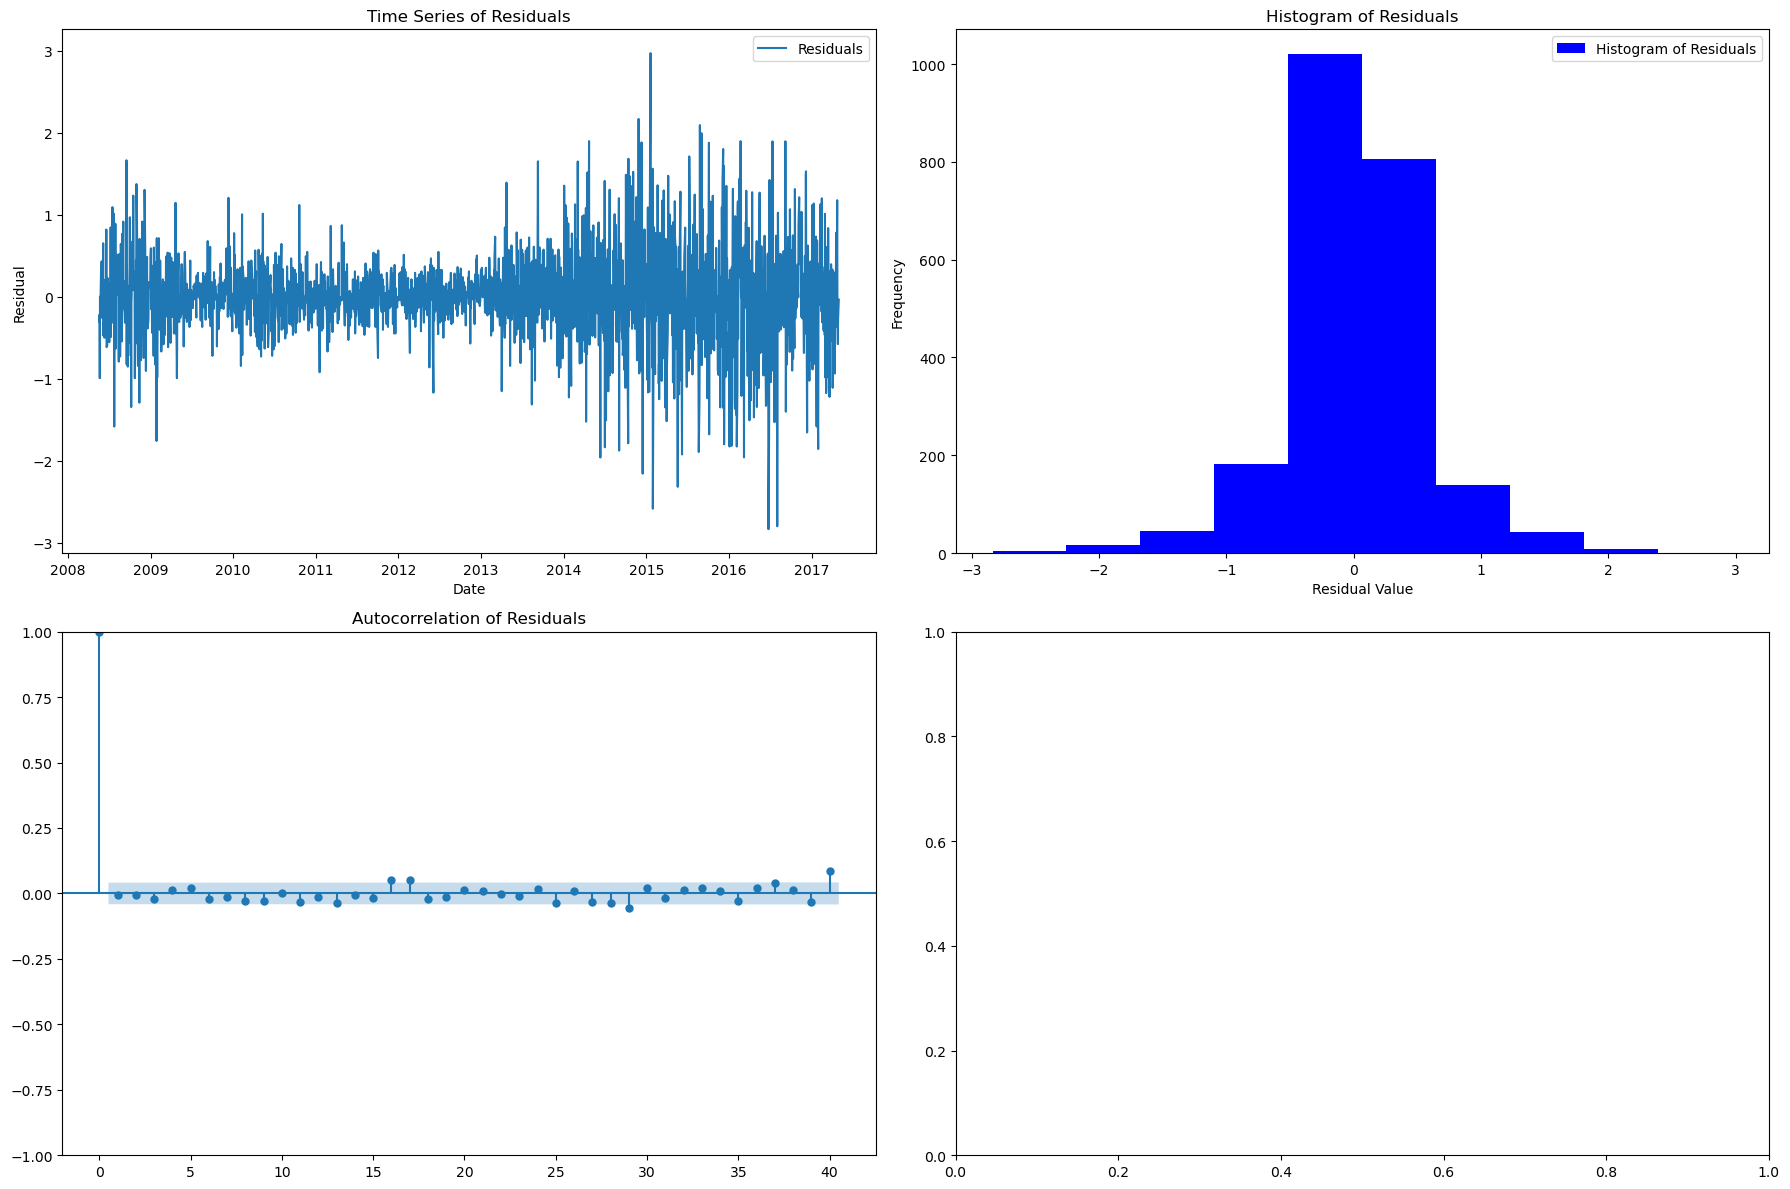

In [27]:
resid = autoarima_model.resid()
analyze_residuals(resid[250:])

In [28]:
predictions_autoarima = autoarima_model.predict(n_periods=len(val_dal))
evaluate_forecast(val_dal['adj_close'], predictions_autoarima)

,MAE,MSE,MAPE (%),sMAPE (%)
0,10.604609,133.656219,24.601304,24.2591


## 6.Prophet

In [29]:
train = train_dal.copy() 
valid = val_dal.copy()

In [30]:
train.rename(columns= {'adj_close': 'y'}, inplace = True)
train.index.name = 'ds'
train['ds'] = train.index
train = train.reset_index(drop=True)
valid.rename(columns= {'adj_close': 'y'}, inplace = True)
valid.index.name = 'ds'
valid['ds'] = valid.index
valid = valid.reset_index(drop=True)

In [31]:
model_prophet = Prophet()
model_prophet.fit(train)

19:17:32 - cmdstanpy - INFO - Chain [1] start processing
19:17:33 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
future_data = model_prophet.make_future_dataframe(periods=2*12, freq='m')
forecast_data = model_prophet.predict(future_data)

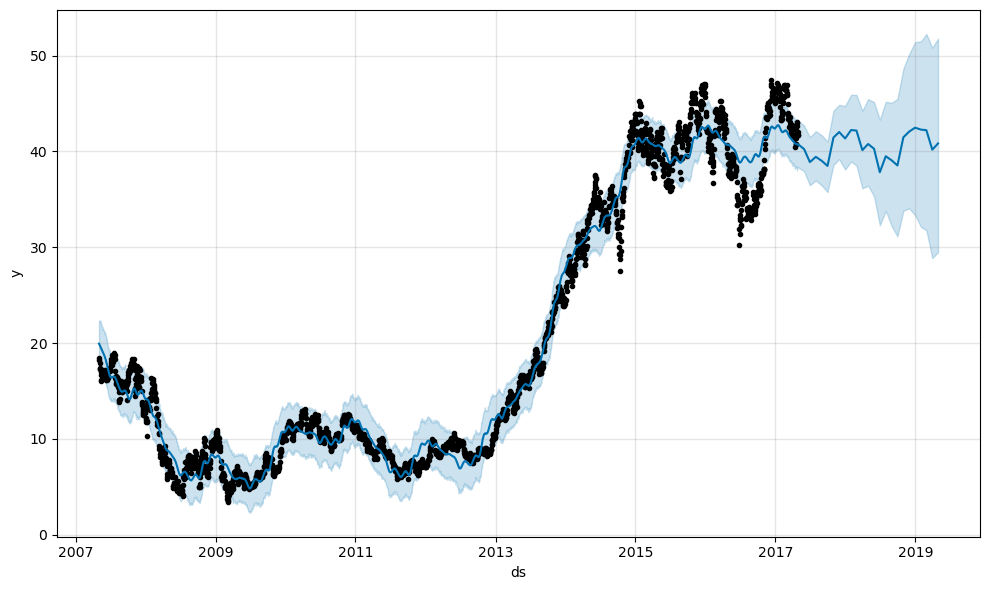

In [33]:
p = model_prophet.plot(forecast_data)

'Ljung-Box Test Results:'

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,14985.208468,0.0,14938.720481,0.0


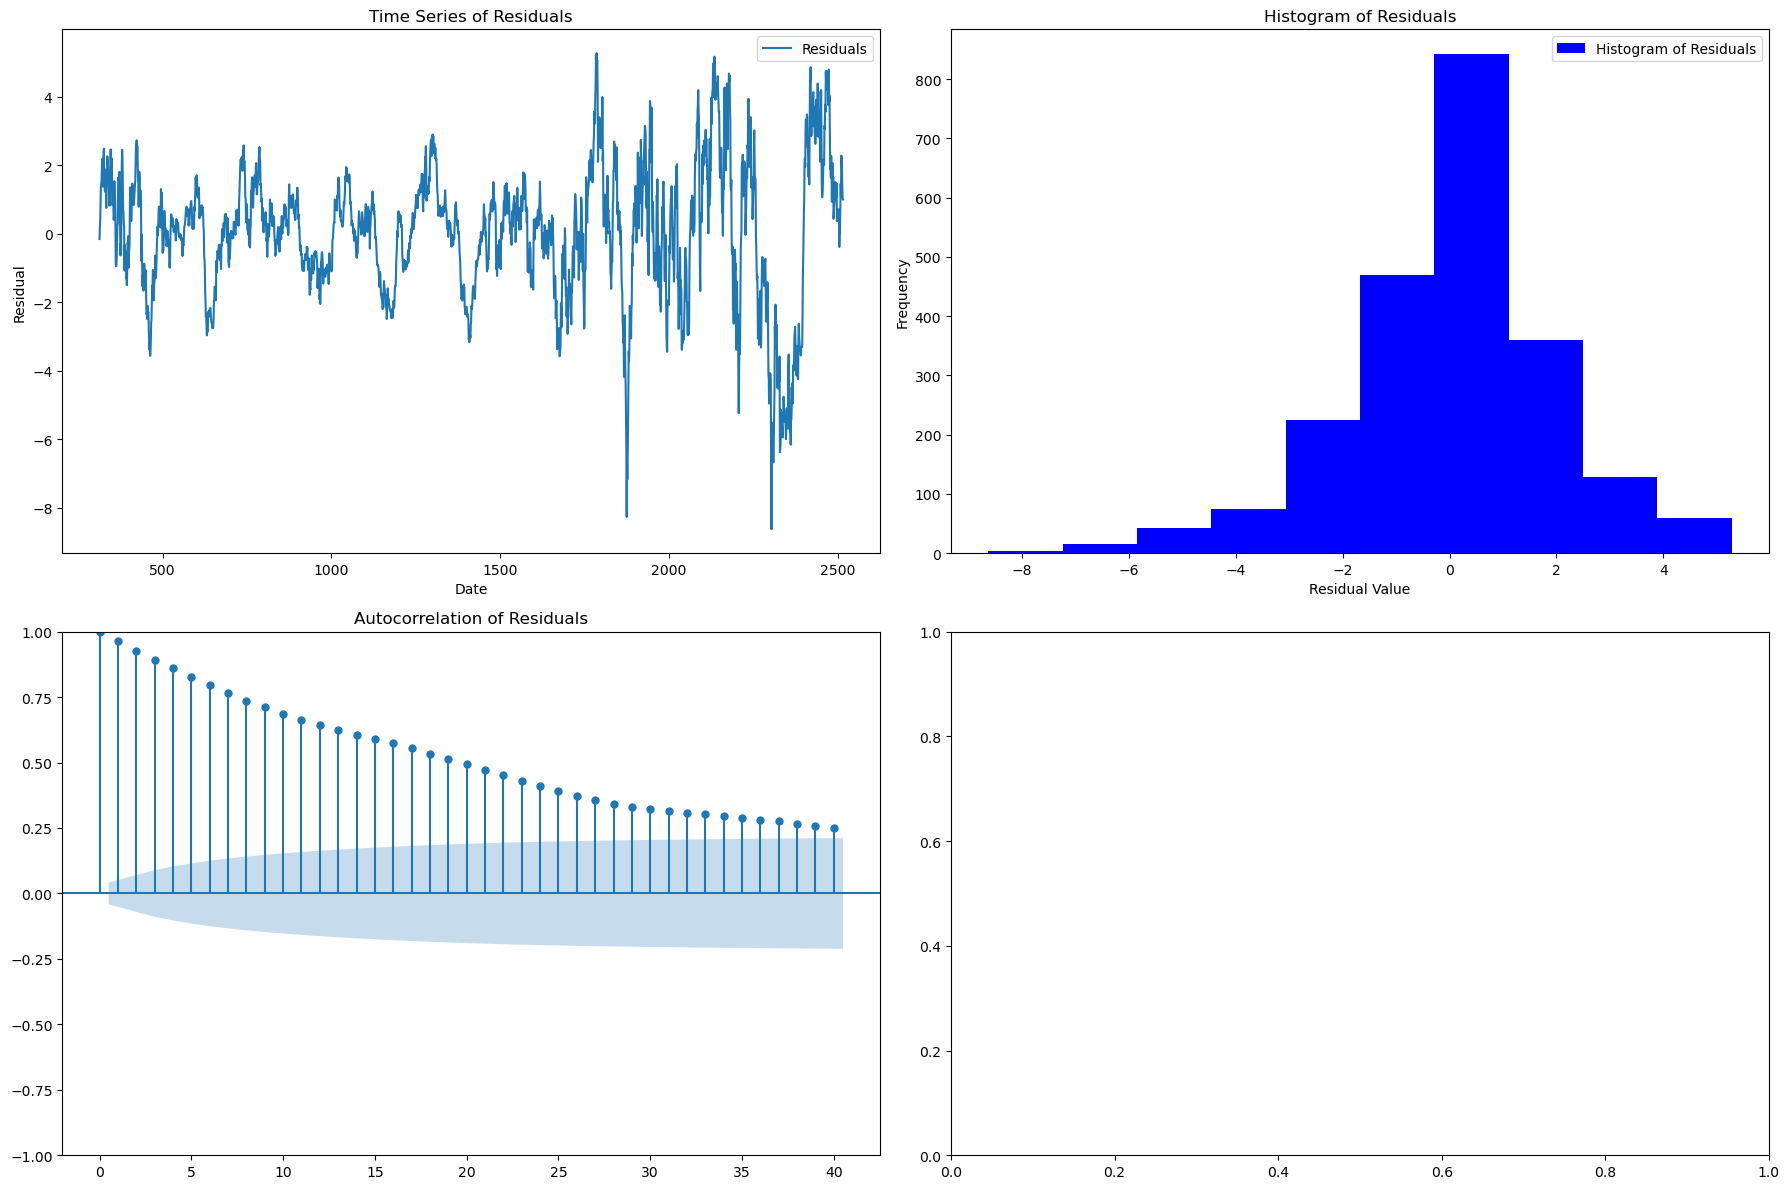

In [34]:
train['resid'] = train['y'] - forecast_data['yhat']
resid_prophet = train['resid']
analyze_residuals(resid_prophet[300:])

## 7. VARMA(with SPY)

In [55]:
SPY = get_ETF_data('SPY', '2000-01-01', '2024-01-01')   

In [57]:
varma_dal = DAL.merge(SPY, left_index=True, right_index=True, how='left').dropna()

In [63]:
train_varma, val_varma, test_varma = split_time_series(varma_dal, 0.6,0.2)

In [59]:
from statsmodels.tsa.vector_ar.var_model import VAR

var_model = VAR(varma_dal).fit()
yhat = var_model.forecast(var_model.endog, steps=1)
print(yhat)

[[ 40.07590813 475.52666225]]


In [60]:
var_model=VAR(train_varma)

results_aic =[]
for p in range(1,10):
    results = var_model.fit(p)
    results_aic.append(results.aic)

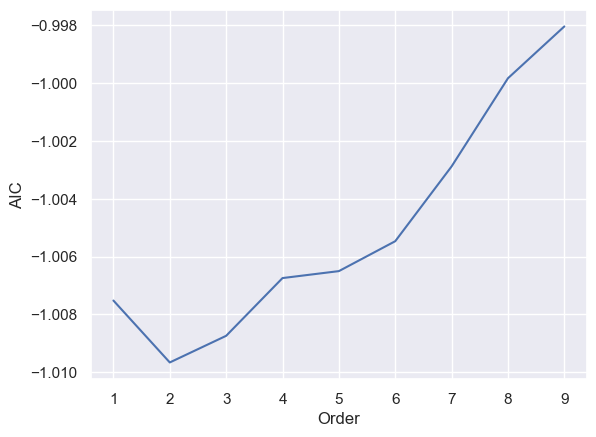

In [61]:
import seaborn as sns
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [62]:
results = var_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 23, May, 2024
Time:                     21:11:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.986482
Nobs:                     2515.00    HQIC:                  -1.00125
Log likelihood:          -5857.61    FPE:                   0.364342
AIC:                     -1.00966    Det(Omega_mle):        0.362898
--------------------------------------------------------------------
Results for equation adj_close_x
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.091237         0.056830           -1.605           0.108
L1.adj_close_x         0.993945         0.022727           43.733           0.000
L1.adj_close_y         0.008625         0.009332  

In [ ]:
yhat = results.forecast(var_model.endog, steps=len(val_varma))

In [ ]:
idx=test_var_duk.index
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.columns =[['duk_forecast', 'spy_forecast']]

In [ ]:
df_results = pd.concat([test_var_duk,df_preds], axis=1)
df_results.plot()

In [ ]:
df_results.columns = [col[0] if isinstance(col, tuple) else col for col in df_results.columns]

## 8. TBATS

In [47]:
train_dal.index = pd.date_range(start=train_dal.index[0], periods=len(train_dal), freq='B')
val_dal.index = pd.date_range(start=val_dal.index[0], periods=len(val_dal), freq='B')

In [50]:
bats_forecaster = BATS(
    use_box_cox=True,
    box_cox_bounds=(0, 1),
    use_trend=True,
    use_damped_trend=None,
    sp=12,
    use_arma_errors=True,
    show_warnings=True,
    n_jobs=None,
    multiprocessing_start_method='spawn',
    context=None,

)

bats_forecaster.fit(train_dal)

BATS(sp=12, use_box_cox=True, use_trend=True)

In [51]:
fh_list = list(range(1,len(val_dal)+1))

In [52]:
ypred_bats = bats_forecaster.predict(fh= fh_list)

In [53]:
evaluate_forecast(val_dal['adj_close'],ypred_bats['adj_close'])

,MAE,MSE,MAPE (%),sMAPE (%)
0,10.624843,133.993855,24.632423,24.307649


## 9.GARCH

In [41]:
def fit_garch_model(train_data, p, q):
    model = arch_model(train_data, vol='Garch', p=p, q=q)
    model_fit = model.fit(disp='off')
    return model_fit.aic, model_fit

In [44]:
best_aic = float('inf')
best_model = None
best_pq = None

for p in range(1, 6):
    for q in range(1, 6):
        aic, model_fit = fit_garch_model(train_dal['adj_close'], p, q)
        if aic < best_aic:
            best_aic = aic
            best_model = model_fit
            best_pq = (p, q)
best_pq

(1, 5)

In [45]:
forecast = best_model.forecast(horizon=len(val_dal))
forecast = pd.Series(forecast.variance.values[-1,:], index=val_dal.index)

In [54]:
evaluate_forecast(val_dal['adj_close'], forecast)   

,MAE,MSE,MAPE (%),sMAPE (%)
0,1066.226829,1.136973e+06,2381.186174,183.515463


## 10.Model Selection 

## 11. Result display 